In [0]:
#Imports the print function from newer versions of python
from __future__ import print_function

%tensorflow_version 1.x
%matplotlib inline

In [0]:
import numpy as np

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
zip_path = "/content/drive/My Drive/Object_Detection_from_Satellite_Imagery_Data/SIMD.zip"

In [4]:
!unzip '$zip_path' -d ./data/
!unzip -q 'data/SIMS dataset/images.zip' -d data/
!unzip -q 'data/SIMS dataset/Annotations_in_3_formats.zip' -d data

Archive:  /content/drive/My Drive/Object_Detection_from_Satellite_Imagery_Data/SIMD.zip
  inflating: ./data/SIMS dataset/test.txt  
  inflating: ./data/SIMS dataset/training.txt  
  inflating: ./data/SIMS dataset/validation.txt  
  inflating: ./data/SIMS dataset/Assignment-2_modified scope.pdf  
  inflating: ./data/SIMS dataset/Annotations_in_3_formats.zip  
  inflating: ./data/SIMS dataset/images.zip  


In [0]:
import os, csv, PIL

def create_csv(txt_path, output_path, class_mapping):
  """
  Creates a csv file that can be used with keras-retinanet csv generator
  (Dependencies: [os, csv, PIL])
  """
  # A subfunction to read annotations file
  def read_ann(ann_path):
    with open(ann_path, 'r') as f:
      lines = f.readlines()
    return lines

  # A subfunction to convert percentage centre 
  # co-ordinates to x1, y1, x2, y2 absolute co-ordinates
  def get_abs_coord(coords, im_w, im_h):
    n_coords = coords.copy()
    n_coords[0] = (coords[0] - (coords[2]/2)) * im_w
    n_coords[2] = n_coords[0] + (coords[2] * im_w)
    n_coords[1] = (coords[1] - (coords[3]/2)) * im_h
    n_coords[3] = n_coords[1] + (coords[3] * im_h)

    return list(map(int, n_coords))

  # Class ID to name mapping
  id_to_name = class_mapping

  # create_csv continues.
  # A bit of mangling with the path
  root = '/content/data'
  # CSV list to keep track of the lines needed to be written to the csv
  csv_list = []
  with open(txt_path, 'r') as f:
    line = f.readline()
    while line:
      # Get images path
      im_path = line.strip()
      abs_im_path = root + '/' + "/".join(line.strip().split('/')[1:])
      # Get path of annotations for the image
      im_txt_path = os.path.splitext(abs_im_path)[0] + '.txt'
      # Get the annotations
      anns = read_ann(im_txt_path)
      for ann in anns:
        items = ann.strip().split(' ')
        c_id, bb = int(items[0]), list(map(float, items[1:]))
        # Get the size of the image
        w, h = PIL.Image.open(abs_im_path).size
        # Get absolute co-ordinates
        bb = get_abs_coord(bb, w, h)
        # Row for csv file, converting x,y,w,h to x,y,x1, y1
        csv_list.append([abs_im_path, *bb, id_to_name[c_id]])
      # Read next line
      line = f.readline()

    with open(output_path, 'w', newline="") as f:
      writer = csv.writer(f)
      writer.writerows(csv_list)
        

In [0]:
class_mapping = ['Car', 'Truck', 'Van', 'LongVehicle', 'Bus', 
                'Airliner', 'Propeller Aircraft', 'Trainer Aircraft', 'Chartered Aircraft',
                'Fighter Aircraft', 'Others', 'Stair Truck', 'Pushback Truck',
                'Helicopter', 'Boat']
class_mapping = dict(enumerate(class_mapping))

create_csv('data/SIMS dataset/training.txt', 'data/training.csv', class_mapping)
create_csv('data/SIMS dataset/test.txt', 'data/test.csv', class_mapping)
create_csv('data/SIMS dataset/validation.txt', 'data/validation.csv', class_mapping)

class_csv = list(map(lambda x: (x[1], x[0]), class_mapping.items()))

with open('data/classes.csv', 'w', newline="") as f:
  writer = csv.writer(f)
  writer.writerows(class_csv)

In [7]:
!git clone https://github.com/kbardool/keras-frcnn
!mv keras-frcnn/* .
!rm -r keras-frcnn
!pip install -r requirements.txt

Cloning into 'keras-frcnn'...
remote: Enumerating objects: 589, done.
remote: Total 589 (delta 0), reused 0 (delta 0), pack-reused 589
Receiving objects: 100% (589/589), 173.38 KiB | 739.00 KiB/s, done.
Resolving deltas: 100% (402/402), done.
     |████████████████████████████████| 204kB 8.1MB/s 
  Created wheel for Keras: filename=Keras-2.0.3-cp36-none-any.whl size=232962 sha256=a697e6ec5bc6bba681e02ea6a8eb862c78ee82177eb6c78bb286c01e73b85173
  Stored in directory: /root/.cache/pip/wheels/a6/fb/de/faea9e49d563a35f198c6dede7f9260074b5beb8f9bffaaaa1
Successfully built Keras
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.3 which is incompatible.
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [8]:
!python train_frcnn.py -o simple -p data/training.csv --num_epochs 1

Using TensorFlow backend.
Parsing annotation files
Training images per class:
{'Airliner': 756,
 'Boat': 3965,
 'Bus': 1337,
 'Car': 8861,
 'Chartered Aircraft': 485,
 'Fighter Aircraft': 41,
 'Helicopter': 44,
 'LongVehicle': 1241,
 'Others': 595,
 'Propeller Aircraft': 154,
 'Pushback Truck': 141,
 'Stair Truck': 317,
 'Trainer Aircraft': 490,
 'Truck': 1936,
 'Van': 3510,
 'bg': 0}
Num classes (including bg) = 16
Config has been written to config.pickle, and can be loaded when testing to ensure correct results
Num train samples 2707
Num val samples 526







Instructions for updating:
keep_dims is deprecated, use keepdims instead
loading weights from resnet50_weights_tf_dim_ordering_tf_kernels.h5
Could not load pretrained model weights. Weights can be found in the keras application folder 		https://github.com/fchollet/keras/tree/master/keras/applications


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
keep_d

In [38]:
!pip install keras==2.1.5

In [0]:
%matplotlib inline

{0: 'Car', 1: 'Chartered Aircraft', 2: 'Airliner', 3: 'Van', 4: 'Others', 5: 'Stair Truck', 6: 'Pushback Truck', 7: 'Bus', 8: 'Truck', 9: 'Helicopter', 10: 'Propeller Aircraft', 11: 'Boat', 12: 'Trainer Aircraft', 13: 'LongVehicle', 14: 'Fighter Aircraft', 15: 'bg'}
Loading weights from ./model_frcnn.hdf5
0884.jpg
Elapsed time = 3.447936534881592
[]


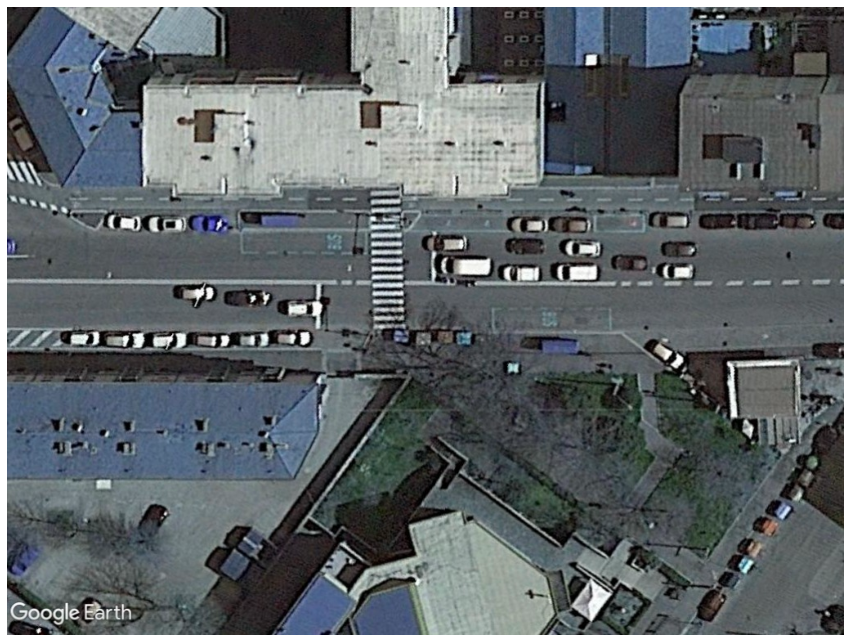

In [67]:
from __future__ import division
import os
import cv2
import numpy as np
import sys
import pickle
from optparse import OptionParser
import time
from keras_frcnn import config
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers

sys.setrecursionlimit(40000)

parser = OptionParser()

test_path="test"
num_rois=32
config_filename="config.pickle"
network='resnet50'


config_output_filename = config_filename

with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

if C.network == 'resnet50':
	import keras_frcnn.resnet as nn
elif C.network == 'vgg':
	import keras_frcnn.vgg as nn

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

img_path = test_path

def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

class_mapping = C.class_mapping

if 'bg' not in class_mapping:
	class_mapping['bg'] = len(class_mapping)

class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}
C.num_rois = int(num_rois)

if C.network == 'resnet50':
	num_features = 1024
elif C.network == 'vgg':
	num_features = 512

if K.image_dim_ordering() == 'th':
	input_shape_img = (3, None, None)
	input_shape_features = (num_features, None, None)
else:
	input_shape_img = (None, None, 3)
	input_shape_features = (None, None, num_features)


img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

all_imgs = []

classes = {}

bbox_threshold = 0.8

visualise = True

for idx, img_name in enumerate(sorted(os.listdir(img_path))):
	if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
		continue
	print(img_name)
	st = time.time()
	filepath = os.path.join(img_path,img_name)

	img = cv2.imread(filepath)

	X, ratio = format_img(img, C)

	if K.image_dim_ordering() == 'tf':
		X = np.transpose(X, (0, 2, 3, 1))

	# get the feature maps and output from the RPN
	[Y1, Y2, F] = model_rpn.predict(X)
	

	R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)

	# convert from (x1,y1,x2,y2) to (x,y,w,h)
	R[:, 2] -= R[:, 0]
	R[:, 3] -= R[:, 1]

	# apply the spatial pyramid pooling to the proposed regions
	bboxes = {}
	probs = {}

	for jk in range(R.shape[0]//C.num_rois + 1):
		ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
		if ROIs.shape[1] == 0:
			break

		if jk == R.shape[0]//C.num_rois:
			#pad R
			curr_shape = ROIs.shape
			target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
			ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
			ROIs_padded[:, :curr_shape[1], :] = ROIs
			ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
			ROIs = ROIs_padded

		[P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

		for ii in range(P_cls.shape[1]):

			if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
				continue

			cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

			if cls_name not in bboxes:
				bboxes[cls_name] = []
				probs[cls_name] = []

			(x, y, w, h) = ROIs[0, ii, :]

			cls_num = np.argmax(P_cls[0, ii, :])
			try:
				(tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
				tx /= C.classifier_regr_std[0]
				ty /= C.classifier_regr_std[1]
				tw /= C.classifier_regr_std[2]
				th /= C.classifier_regr_std[3]
				x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
			except:
				pass
			bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
			probs[cls_name].append(np.max(P_cls[0, ii, :]))

	all_dets = []

	for key in bboxes:
		bbox = np.array(bboxes[key])

		new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
		for jk in range(new_boxes.shape[0]):
			(x1, y1, x2, y2) = new_boxes[jk,:]

			(real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

			cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),2)

			textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
			all_dets.append((key,100*new_probs[jk]))

			(retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
			textOrg = (real_x1, real_y1-0)

			cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
			cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
			cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

	print('Elapsed time = {}'.format(time.time() - st))
	print(all_dets)
	import matplotlib.pyplot as plt
	plt.figure(figsize=(15, 15))
	plt.axis('off')
	plt.imshow(img)
	plt.show()